<a href="https://colab.research.google.com/github/foramirez50/DeepLearning/blob/main/Taller3DLv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)


# **Taller 3**

La comunidad científica es de la comunidad más activa que existe a la hora de realizar publicaciones en grandes revistas. Los avances tecnológicos, las facilidades a la hora de encontrar información y la gran cantidad de médicos dedicados a realizar estudios y publicarlos ha aumentado a tal punto que realizar una categorización de estos textos sería ideal para poder filtrar la información y acceder a ella de una manera más rápida y precisa.

Para eso, le han disponibilizado los *Abstracts* de diferentes artículos de los cuales los expertos los han clasificado en diferentes categorias, la idea es poder automatizar este proceso para que futuros artículos puedan ser clasificados automáticamente sin necesidad de disponer del tiempo de los expertos.

Para resolver el modelo, es importante que construyan la mejor Red Neuronal Recurrente que puedan encontrar. El procesamiento, la tokenización, la limpieza de los textos, la definición de los Embedding y la arquitectura de la Red Neuronal, así como la utilización de Redes Preentrenadas están a su criterio. Lo importante es documentar todos los pasos anteriormente descritos.

Datos: https://raw.githubusercontent.com/Camilojaravila/202210_MINE-4206_ANALISIS_CON_MACHINE_LEARNING/main/Taller%202/train.dat

## **INTEGRANTES**

FABIAN ORLANDO RAMIREZ

DAVID AUGUSTO VASQUEZ

## INSTALACIÓN DE LIBRERÍAS Y SUBIDA DEL DATASET

In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D
from tensorflow.keras import losses

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.9.2


In [2]:
url = "https://raw.githubusercontent.com/Camilojaravila/202210_MINE-4206_ANALISIS_CON_MACHINE_LEARNING/main/Taller%202/train.dat"

dataset = tf.keras.utils.get_file('/content/abstract.dat', url)

In [3]:
file = "/content/abstract.dat"
with open(file) as f:
    mylist = [line.rstrip('\n') for line in f]

In [4]:
# este procedimiento se hizo para mostrar que el dataset está desbalanceado, 
df = pd.DataFrame (mylist, columns = ['class'])
df[['labels','text']] = df['class'].str.split('\t',1,expand=True)
df.labels.value_counts()

5    4805
1    3163
4    3051
3    1925
2    1494
Name: labels, dtype: int64

## CRITERIO 1: PROCESAMIENTO DE TEXTO

In [5]:
# se convierte el dataset de .dat a un dataset de tf con la librería TextLineDataset
ds_tensor = tf.data.TextLineDataset(dataset)

In [6]:
# se ve el tipo y la clase de dataset que se tiene TextLineDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)
print("dataset class............", type(ds_tensor))
print("dataset type.............",ds_tensor)

dataset class............ <class 'tensorflow.python.data.ops.readers.TextLineDatasetV2'>
dataset type............. <TextLineDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [7]:
# con esta función, dividimos los vectores en labels y text, pero además de esto le hacemos un cast para definir los tipos (dtypes)
def get_split_tensor(text):
  dataset_split = tf.strings.split(text,sep='\t')
  call_label = tf.cast(dataset_split[1], tf.string)
  call_text = tf.cast(int(dataset_split[0]),tf.int64)
  return call_label , call_text

In [8]:
# se hace un mapeo para la tranformación con la función de spli y cast los tensores
ds_tensor_splited = ds_tensor.map(get_split_tensor)

In [9]:
# en esta parte se ve la transformación del .map a MapDataset
# aquí se puede observar las 2 partes del tensor, la parte del label (int.64) y la parte del texto (string)
print("dataset class............", type(ds_tensor_splited))
print("dataset type.............",ds_tensor_splited)

dataset class............ <class 'tensorflow.python.data.ops.dataset_ops.MapDataset'>
dataset type............. <MapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [10]:
# damos un ejemplo con el label y el texto
for text, label in ds_tensor_splited.take(1):
  print("label: ", label.numpy())
  print("Text: ", text.numpy().decode('utf-8'))

label:  4
Text:  Catheterization laboratory events and hospital outcome with direct angioplasty for acute myocardial infarction To assess the safety of direct infarct angioplasty without antecedent thrombolytic therapy, catheterization laboratory and hospital events were assessed in consecutively treated patients with infarctions involving the left anterior descending (n = 100 patients), right (n = 100), and circumflex (n = 50) coronary arteries. The groups of patients were similar for age (left anterior descending coronary artery, 59 years; right coronary artery, 58 years; circumflex coronary artery, 62 years), patients with multivessel disease (left anterior descending coronary artery, 55%; right coronary artery, 55%; circumflex coronary artery, 64%), and patients with initial grade 0/1 antegrade flow (left anterior descending coronary artery, 79%; right coronary artery, 84%; circumflex coronary artery, 90%). Cardiogenic shock was present in eight patients with infarction of the left

In [11]:
#se divide el dataset siguiendo lasl instruccions citadas abajo, con esto sabemos el tamaño del dataset
#https://stackoverflow.com/questions/51125266/how-do-i-split-tensorflow-datasets
DATA_SIZE = len(list(ds_tensor_splited))
print(DATA_SIZE)

14438


In [12]:
# se toma la función hstack para tomas la "y" que serían los labels en el vector
# con esto se encontró los labels del dataset
labels1 = np.hstack([y for x, y in ds_tensor_splited])
CATEGORIES = np.unique(labels1)
print(CATEGORIES)

[1 2 3 4 5]


In [13]:
# El dataset se divide en 20% de test, 16% para validación (el 20% del train) y finalmente el train con un 64%
train_size = int(0.64 * DATA_SIZE)
val_size = int(0.16 * DATA_SIZE)
test_size = int(0.20 * DATA_SIZE)

In [14]:
# se dividen los datasets y "saltan" las partes que están ya en otros grupos
train_ds = ds_tensor_splited.take(train_size).shuffle(1000)
test_ds = ds_tensor_splited.skip(train_size)
val_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

### Se toman muestras y tamaños de los datasets de train, val y test

In [15]:
for text, label in train_ds.take(1):
  print("label: ", label.numpy())
  print("Text: ", text.numpy().decode('utf-8'))
  print("train size", len(list(train_ds)))

label:  4
Text:  Femoral artery cannulation for monitoring in critically ill children: prospective study. Seventy-seven attempted percutaneous femoral artery cannulations were prospectively evaluated in 74 children. Artery cannulation was successfully accomplished in 73 (95%) cases and lasted for a mean of 6 days. Sixty percent of the catheters were inserted on the first attempt. Fifty-two (71%) patients weighed less than 10 kg and 55 (75%) patients were less than 12 months old. Fifty-one (70%) patients received inotropic support at the time of cannulation, and 27 (37%) eventually died from causes unrelated to catheter insertion. There was one episode each of line-associated infection and transient distal ischemia not resulting in tissue loss, and two episodes of catheter malfunction. In eight (11%) patients, signs of distal vascular insufficiency developed shortly catheter placement and resolved after catheter removal. The development of this complication correlated significantly (p l

In [16]:
for text, label in val_ds.take(1):
  print("label: ", label.numpy())
  print("Text: ", text.numpy().decode('utf-8'))
  print("val size", len(list(val_ds)))

label:  1
Text:  Interstitial chemotherapy with drug polymer implants for the treatment of recurrent gliomas. Malignant gliomas have been difficult to treat with chemotherapy. The most effective agent, BCNU (carmustine), has considerable systemic toxicity and a short half-life in serum. To obviate these problems, a method has been developed for the local sustained release of chemotherapeutic agents by their incorporation into biodegradable polymers. Implantation of the drug-impregnated polymer at the tumor site allows prolonged local exposure with minimal systemic exposure. In this Phase I-II study, 21 patients with recurrent malignant glioma were treated with BCNU released interstitially by means of a polyanhydride biodegradable polymer implant. Up to eight polymer wafers were placed in the resection cavity intraoperatively, upon completion of tumor debulking. The polymer releases the therapeutic drug for approximately 3 weeks. Three increasing concentrations of BCNU were studied; the

In [17]:
for text, label in test_ds.take(1):
  print("label: ", label.numpy())
  print("Text: ", text.numpy().decode('utf-8'))
  print("test size", len(list(test_ds)))

label:  5
Text:  Reoperations on heart valve prostheses: an analysis of operative risks and late results. To evaluate risks and complications of reoperations on heart valve prostheses, we reviewed data on 183 patients who underwent reoperation because of prosthetic valve malfunction. The incremental effect of the redo procedure on hospital mortality and morbidity was studied by comparing primary and reoperative procedures and analyzing a series of possible predisposing factors. Late survival after first and second reoperations was computed, and possible determinants of late mortality were examined. Overall operative mortality was 8.7%; emergency operation (p = 0.0001), previous thromboembolism (p = 0.05), and advanced New York Heart Association functional class (p = 0.031) were the independent determinants. In a series of 1,355 patients having primary or secondary isolated valve replacement, the redo procedure was a significant risk factor in the univariate analysis (p = 0.025) but not

### se comprueba que están divididos y que sumados dan el total del dataset  9240+2311+2887 = 14438

In [18]:
# Corremos el AUTOTUNE para optimizar el procesamiento de las variables
AUTOTUNE = tf.data.AUTOTUNE

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
training_data = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
# aquí vemos que de nuevo el tensor cambio de clase a PrefetchDataset element_spec, los componentes int y string siguen igual
print("dataset class............", type(training_data))
print("dataset type.............",training_data)

dataset class............ <class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
dataset type............. <PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [20]:
#import os
#import re
#import string

In [21]:
# se intentó hacer con la función dada por el monitor, pero eso daña el text vectorization, deja el vector con valores entre 0 y 30 y no entre 0 y 12000 como dice el vocabulario

#def custom_standardization(input_data):
#    lowercase = tf.strings.lower(input_data)
#    stripped_html = tf.strings.regex_replace(lowercase, '', ' ')
#    return tf.strings.regex_replace(stripped_html,
#                                  '[%s]' % re.escape(string.punctuation), '')

## CRITERIO 2 : ARQUITECTURA EMBEDDING

In [22]:
# https://www.crowdwriter.com/blog/how-long-should-an-abstract-be según este articulo, el máximo len para un abstract es de 300 palabras en harvard
vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=12000,
    output_mode='int',
    output_sequence_length=300)

In [23]:
# se divide un tf dataset para dejar sólo los textos
text_ds = test_ds.map(lambda text, labels: text)
# y se utiliza el .adapt para determinar la frecuencia de las palabras y crear el vocabulario con estas palabras
vectorize_layer.adapt(text_ds)

In [24]:
# con esto se prueba que el vocabulario esté entre los rangos (12000) 
#se observa que los abstracts que tienen menos palabras se rellenan con "0"
text_batch, label_batch = next(iter(training_data))
text = tf.expand_dims(text_batch, -1)
print(vectorize_layer(text), label_batch)

tf.Tensor(
[[   7    1    1  340    8    1    7 3761  270  105 8771    1   12 3165
   841 6574  841 6295    6    7    1   13    1 1845   16  670   14    7
  3761  270    2    3    1 3798   67   16  687 3294    6 8771    1  150
  8771    1   96  323  631  165   23    7 3455  471    3    1    1  340
     7  280  246    8    1    7 3761  270   10 1501    8  295    9    6
   629   77    5    3 4545    2    7 3165  841 6574   14    3    1 1845
     1 1845 8771    1   11   27  114    3   56   11 2421 1257   12   51
     9   48 1597 5154  177    2 3736    2    3 3761    5   46    4 4475
   270  146  187    8  533  372    2    3 3761  270    5    3   76 2603
     2    3 3761  270   18   19 1071  124   99    7  685 1525 3016 3761
   270   15    1  228    8 5048 6295    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  

## CRITERIO 3: ENTRENAMIENTO DE LA RED NEURONAL RECURRENTE

En esta parte se construyó el modelo, se utilizaron una capa de RNN tipo GRU, por su simplicidad y rapidez de entrenamiento.

El Embeding es de 12000 + 1 teniendo en cuenta las palabras desconocidas
como el embeding es de 32, se coloco el batch también de este tamaño.

Se deja el optimizer Adam por defect y como lideamos con un problema de clasificación colocamos la sparseCategoricalCrossentropy como función de costo


In [25]:
# en esta parte se obtenía un error en la capa de salida, pues se tiene los números de 1 a 5 en el clasificador, por esto se tuvo que sumar 1 en las neuronas de la capa de salida
embedding_dim=32

model_GRU = tf.keras.Sequential([
  vectorize_layer,
  Embedding(12000 + 1, embedding_dim, name="Capa_Embedding"),
  tf.keras.layers.GRU(32, name='Capa_Celdas_GRU'),
  Dense(32, activation='relu', name='Capa_Oculta'),
  Dense(6,name='Capa_Salida')
])

model_GRU.compile(optimizer='adam',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir="logs")
]

batch_size = 32

In [26]:
# se transforma a batch para poder entrenar el modelo, de lo contrario da error. 
training_data_batch = training_data.padded_batch(batch_size)
val_data_batch = val_ds.padded_batch(batch_size)

In [27]:
# Se ve la tranformación en el tipo del conjunto de training y validación de prefech a batch
print("dataset class............", type(training_data_batch))
print("dataset type.............",training_data_batch)
print("dataset class............", type(val_data_batch))
print("dataset type.............",val_data_batch)

dataset class............ <class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'>
dataset type............. <PaddedBatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
dataset class............ <class 'tensorflow.python.data.ops.dataset_ops.PaddedBatchDataset'>
dataset type............. <PaddedBatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [28]:
# se entrena el modelo
log_GRU = model_GRU.fit(
    training_data_batch,
    validation_data=val_data_batch,
    callbacks=callbacks,
    epochs=10)

Epoch 1/10
289/289 [==============================] - 53s 174ms/step - loss: 1.5765 - accuracy: 0.3245 - val_loss: 1.5312 - val_accuracy: 0.3423
Epoch 2/10
289/289 [==============================] - 40s 139ms/step - loss: 1.5386 - accuracy: 0.3226 - val_loss: 1.5308 - val_accuracy: 0.3423
Epoch 3/10
289/289 [==============================] - 36s 124ms/step - loss: 1.5354 - accuracy: 0.3252 - val_loss: 1.5308 - val_accuracy: 0.3414
Epoch 4/10
289/289 [==============================] - 39s 135ms/step - loss: 1.5159 - accuracy: 0.3380 - val_loss: 1.3535 - val_accuracy: 0.4232
Epoch 5/10
289/289 [==============================] - 37s 128ms/step - loss: 1.2574 - accuracy: 0.4595 - val_loss: 1.2302 - val_accuracy: 0.5050
Epoch 6/10
289/289 [==============================] - 38s 131ms/step - loss: 1.0972 - accuracy: 0.5656 - val_loss: 1.2209 - val_accuracy: 0.5110
Epoch 7/10
289/289 [==============================] - 36s 126ms/step - loss: 0.9954 - accuracy: 0.6002 - val_loss: 1.2621 - val_ac

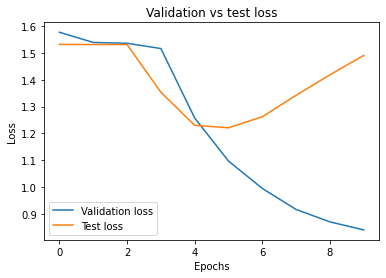

In [29]:
# se hace la gráfica las epocas del entrenamiento para ver si el modelo se sobreajusta
plt.plot(log_GRU.history['loss'], label='Validation loss')
plt.plot(log_GRU.history['val_loss'], label='Test loss')
plt.title('Validation vs test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### en esta gráfica se pude observar que el modelo converge alrededor de la época 5 y despues se sobreajusta (el valor de loss para train y test comienza a diverger)

In [30]:
# ahora se procede a hacer el summary, (antes de esta parte la función daba error)
model_GRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 300)              0         
 torization)                                                     
                                                                 
 Capa_Embedding (Embedding)  (None, 300, 32)           384032    
                                                                 
 Capa_Celdas_GRU (GRU)       (None, 32)                6336      
                                                                 
 Capa_Oculta (Dense)         (None, 32)                1056      
                                                                 
 Capa_Salida (Dense)         (None, 6)                 198       
                                                                 
Total params: 391,622
Trainable params: 391,622
Non-trainable params: 0
__________________________________________________

In [31]:
y_true = list()

for text, labels in training_data_batch:
    pred = model_GRU.predict(text)
    for i in range(len(pred)):
        y_true.append(labels[i].numpy())

y_true = np.array(y_true)

1/1 [==============================] - 0s 468ms/step


In [32]:
y_pred = np.argmax(model_GRU.predict(training_data_batch), axis=1)

print(classification_report(y_true, y_pred=y_pred,target_names=[str(num.item() ) for num in CATEGORIES]))

289/289 [==============================] - 7s 23ms/step
              precision    recall  f1-score   support

           1       0.73      0.95      0.82      2024
           2       0.43      0.61      0.51       970
           3       0.45      0.53      0.49      1243
           4       0.84      0.71      0.77      1974
           5       0.65      0.45      0.53      3029

    accuracy                           0.64      9240
   macro avg       0.62      0.65      0.62      9240
weighted avg       0.66      0.64      0.64      9240



## CRITERIO 4: CONCLUSIONES DEL NEGOCIO

1. dataset está no balanceado: cómo se evidenció desde el principio el dataset estaba desbalanceado, por esta razón los resultados para la clase 2 y 3 dan menor recall en comparación con la clase 5

2. el mejor modelo GRU: Se realizaron algunas iteraciones con el modelo, pero el modelo más simple con el mejor desempeño fue el que se presenta, de ahí se modificaron algunos hyperparámetros para que dieran mejores resultados.

Se obvio las LTSM pues este modelo es relativamene corto (300 palabras máximo) y con una arquitectura tan pequeña no debería tener desvanecimiento de gradiente. También se consultó que las [LTSM](https://medium.com/mindboard/lstm-vs-gru-experimental-comparison-955820c21e8b) tiene una mayor volatilidad. Por esta razón no se hicieron pruebas con el LTSM

3. entendimiento del negocio, ¿cómo se modificaron los hyperparámetros?

Embedding: el embedding se modificó a 300 palabras, esto con base en la longuitud máxima de los abstracts, que bajo la regulación de Harvard son 300 palabras.

Vocabulario: el vocabulario se maximizó (12.000 palabras), teniendo en cuenta la especificidad del contexto, pues cada abstract tiene sus palabras específicas y maximizando esto, ayuda mucho a realizar mejores clasificaciones

Entrenamiento: con un aumento progresivo de los hyperparámetros anteriormente mencionados, se observó una mejora considerable en presición y recall, por este motivo, se dejó el mejor modelo con estos parámetros maximizados.
